# Anomaly Detection

In this notebook we will locate anomalous data in a dataset using two different approaches: 

* KMeans Clustering
* Isolation Forests

We will visualize anomalous data by reducing the dimensionality using PCA

The data we are using is regarding HVAC operation in a building.  It includes sensor data describing temperatures, humidity, and power needed by fans.

The dataset was downloaded from Mendeley Data and contributed by Davide Borda.  It can be found [here.](https://data.mendeley.com/datasets/mjhr46dkj6/1)

## Data Description

1. timestamp;
2. temperatures of return, supply and outdoor air [°C];
3. relative humidities of return, supply and outdoor air [%];
4. the temperature setpoint of the return air [°C];
5. the saturation temperature in the humidifier [°C];
6.  power required by the fans [kW];
7. energy required by the fans [kWh].

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.metrics import silhouette_score
set_config(transform_output='pandas')

# Load Data and Initial EDA

In [ ]:
df = pd.read_csv('Data/HVAC_Data.csv', sep=';')
df.head()

We could use strategies for timeseries anomaly detection, but in this notebook we are focusing on non-timeseries strategies.  We will set the time as the index anyway, in case we want to do future analysis.

In [ ]:
df.info()

In [ ]:
## remove GMT offset and convert to datetime
df['Timestamp'] = df['Timestamp'].str.split('+').str[0]

format = '%Y-%m-%d %H:%M:%S'
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df.info()

## Distributions

In [ ]:
df.hist(figsize=(12,12));

Many of the features are close to normally distributed, but there are some long tails on some of them.  

In [ ]:
df.boxplot(figsize=(12,12))

With the exception of SP_Return there don't seem to be many extreme outliers.

# KMeans

In this section we will use a KMeans model to determine outlier data.

Steps:
1. Determine k number of clusters
2. Identify cluster centers and measure distance between each data point and each cluster center.
3. Label points farthest away from any cluster center as outliers.

## Prepare the Data

Since this is unsupervised, we do not need to perform a validation split.  However, we do need to scale the data for KMeans models.

In [ ]:
## Scale the data
df_scaled = StandardScaler().fit_transform(df)
df_scaled.describe()

# Determine a value for K

fitting KMeans with 2 clusters
fitting KMeans with 3 clusters
fitting KMeans with 4 clusters
fitting KMeans with 5 clusters
fitting KMeans with 6 clusters
fitting KMeans with 7 clusters
fitting KMeans with 8 clusters
fitting KMeans with 9 clusters
fitting KMeans with 10 clusters


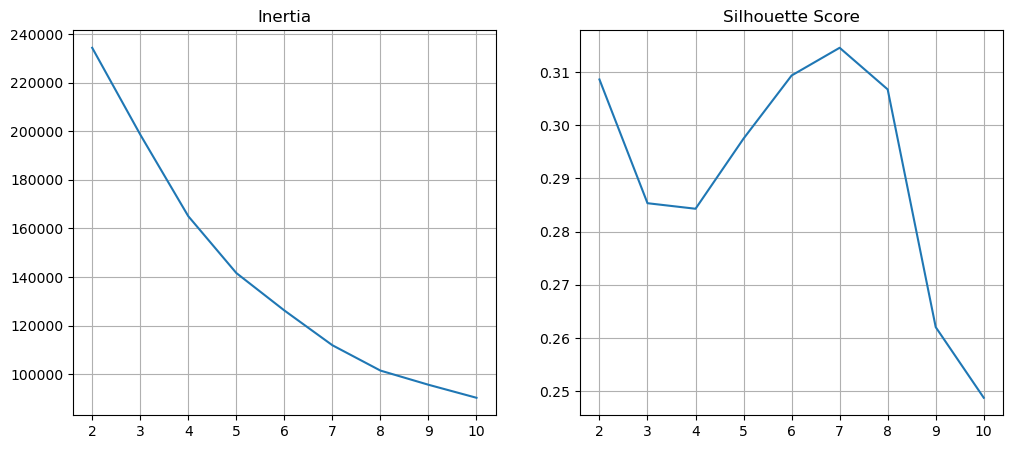

In [9]:
## Create a range of k numbers of clusters
ks = range(2,11)

## Create lists to hold the inertia and silhouette scores
inertias = []
sils = []

## Loop over k values to determine the best number of clusters for the model
for k in ks:
    ## create and fit a KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled)
    print(f'fitting KMeans with {k} clusters')
    
    ## Append the inertia and silhouette scores to the lists
    inertias.append(kmeans.inertia_)
    sils.append(silhouette_score(df_scaled, kmeans.labels_))

## Plot the inertias and silhouette scores to determine the right number of clusters
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(ks, inertias)
axes[0].grid()
axes[0].set_title('Inertia')

axes[1].plot(ks, sils)
axes[1].set_title('Silhouette Score')
axes[1].grid()

## Fit final KMeans

Now that we have found the optimal number of clusters, we will fit our final KMeans model.

In [ ]:
n_clusters = ##How many clusters?
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(df_scaled)

## Determine distance from cluster centers.

We will use the `scipy.spatial.distance.cdist` package to find the distances between each scaled datapoint and each cluster center.  This will be an array with one row per data point and one column per cluster center.

In [ ]:
## Find distances
from scipy.spatial.distance import cdist



## Find the distance to the closest cluster for each data point.  

How far is each datapoint from it's cluster center?  The data points that are farthest from their closest cluster center will be labeled anomalies.

In [ ]:
# Find the minimum distance to a cluster center for each data point.



In [ ]:
## Examine a histogram of minimum distances



## Determine a Threshold for Anomalies

We can see in the plot above that we have some outliers in distances.  The distribution is fairly normal until about 3ish.

A more rigorous way than just eyeballing this would be to choose a percentile.  Let's see what a 99.7th percentile, or 3 standard deviations, cutoff would look like.  This means isolating any points that are farther away from the closest cluster center than 99.7% of other points.  0.3% of data points would be classified as outliers.

In [ ]:
## Determine 99.7th percentile distance threshold



In [ ]:
## Plot a histogram of distances to closest cluster



## Add a vertical span at the 99.7% mark.



## Isolate data points above the threshold

In [ ]:
## Create a filter for which data points are outside the distance threshold



## Filter the original dataset to inspect the anomalous data



We can see that we seem to have stretches of anomalous points.  Our data is in 15 minutes increments and our anamalous seem to come in sequences.  let's see if we can visualize this.

Let's compare it to the outdoor temperature

## Visualizing KMeans Anomalies with PCA


In order to visualize the clusters and anomalies, we need to flatten the data down to 2 dimensions.  We can use PCA for this.

In [ ]:
from sklearn.decomposition import PCA

## instantiate PCA



## PCA transform data



## filter anomalies



## Plot clusters and anomalies
plt.scatter(data_to_plot.iloc[:,0], data_to_plot.iloc[:,1], c=kmeans.labels_)
plt.scatter(kmeans_anomalies.iloc[:,0], kmeans_anomalies.iloc[:,1], c='red', label='anomaly')
plt.title('Clusters and Anomalies')
plt.legend()

Some of the anomalies are at the edges of the main cluster, but others are in the center.  This doesn't much help us visualize them in this case.

In [ ]:
## Plot as time series



## add vertical line at each anomaly



We do seem to have some missing data for a few summer between May and November 2020, but we can see some long stretches of time with anomalies in the warmest months

# Isolation forests

Isolation forests take a different approach.  They create a series of decision trees and determine which datapoints are reachable on the tree via the shortest paths.  Since this is an ensemble model, it will make many trees and average the distances from origin node (root) to terminal node (leaf)

Steps:

1. Instantiate the model.  We need to set a 'contamination' level, or what percentage of the data we think will be anomalies.  Since we used 3 STDs for the KMeans model, we will try the same here.  The inverse of 99.7 is 0.3 percent, or .003.
2. Make predictions using the model.  In this case, non-anomalies will be marked as 1 and anomalies will be -1.
3. Make a filter using the predictions
4. Filter and visualize the data.

## Create and fit the model.

We will set a contamination of .003 so we get the same number of anomalies as the KMeans.  Normally we would use either statistical methods or business knowledge to set the contamination rate.

In [ ]:
## Import IsolationForest
from sklearn.ensemble import IsolationForest

## As a tree-based model, the data does not need to be scaled.  
## Set contamination to .003



## Make predictions



## Create a Filter

We will create a filter where the model predicted -1 (anomaly)

In [ ]:
## Create a filter



We can see above that this forest only seemed to flag the first period that the KMeans flagged, but not the 2nd time frame.  let's visualize it.

## Visualizing IsolationForest Anomalies with PCA

In [ ]:

## filter anomalies



## Plot data and anomalies
plt.scatter(data_to_plot.iloc[:,0], data_to_plot.iloc[:,1], c='green', label='normal')
plt.scatter(iso_anomalies_to_plot.iloc[:,0], iso_anomalies_to_plot.iloc[:,1], c='Orange', label='Isolation Forest Anomaly')

In [ ]:
## Plot as time series



## add vertical line at each anomaly



# Compare KMeans and Isolation Forest

We can already see that our models do not agree on all anomalies, let's compare them to get a better sense of the overlap.

We will:
1. See how many points they agree on
2. See which points they agree on
3. Compare the statistics on the samples they agree on
4. Plot the points to compare.

In [ ]:
## What percent of the data do the models agree are anomalous?

## Find where models agree on an anomaly 



## Count how many they agree on
percent_agree = 100 * len(agree_anomaly) / len(df)
print(f'Of {len(iso_anomalies)} samples that each model identified as anomalous, they agree on {len(agree_anomaly)}.  This is {percent_agree}% of the total data')

In [ ]:
## Inspect the samples that the models agree on



These are all on between October 15th and October 18th, 2019.  This may lead us to believe that something strange was happening during this time period with the HVAC system.  This is also within 9 hours of the beginning of the data collected.  It may be that this was shortly after the system was installed.  We can also see that the relative humidity outside (RH_outside) was very high.

## Compare statistics for anomalous data vs all data

In [ ]:
## Describe the anomalous data



In [ ]:
## Descibe all of the data


We see here that that average humidity, energy, and power are all much higher in the anomalous data both models agree on than in the data overall.

## Visualize Agreed Upon Anomalies

In [ ]:
## Plot data and anomalies
plt.scatter(data_to_plot.iloc[:,0], data_to_plot.iloc[:,1], c='green', label='normal')
plt.scatter(iso_anomalies_to_plot.iloc[:,0], iso_anomalies_to_plot.iloc[:,1], c='red', label='Isolation Forest Anomaly')
plt.scatter(kmeans_anomalies.iloc[:,0], kmeans_anomalies.iloc[:,1], c='blue', label='KMeans Anomaly')
plt.scatter(agree_anomaly.iloc[:,0], agree_anomaly.iloc[:,1], c='purple', label='Kmeans and Iso Agree')

plt.title('Comparing Anomalies')
plt.legend(bbox_to_anchor=[1,1])

In [ ]:
## Plot as time series
ax = df['T_Outdoor'].plot()

## add vertical line at each anomaly
for anom in df[agree_filter].index:
    ax.axvline(anom, color='red')

In this notebook we looked for anomalous data in measurements taking from an HVAC system using KMeans and Isolation Forest models.  We found that on the rows they agree on they humidity was much higher and the system was using more power and energy.

We examined the rows, summary statistics, and visualized the data to build our understanding of the anomalies.